In [1]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import os

## Load data

In [137]:
# load data
root = os.getcwd()
dataset_dir = os.path.join(root, 'Data_60')

In [135]:
raw_df = pd.DataFrame()

In [265]:
# Initialize an empty list to store data
data_list = []

list_of_folders = os.listdir(dataset_dir)

fs  = 1/100000 #Hz
first_iter = True

n_harmonics = 100
# Read matlab files
for folder in list_of_folders:
    path = os.path.join(dataset_dir, folder)
    list_of_files = os.listdir(path)
    label = str(folder)
    print(label)
    for file in list_of_files:
        if file.endswith('.mat'):
            # Read matlab file
            mat = scipy.io.loadmat(os.path.join(path, file))

            # Get data and append to the list
            ft =np.fft.fft(mat['tpd']['Data'][0][0][0])
            if first_iter:
                freqs = np.fft.fftfreq(len(mat['tpd']['Data'][0][0][0]), fs)
                h_index = np.where(freqs % 60 == 0)[0]
                print("harmonics indicies", h_index)
                fc_low = 57
                fc_high = 63
                w = np.zeros(len(freqs))
                w[np.where(fc_high<freqs)] = 1
                w[np.where(freqs<fc_low)] = 1
                first_iter = False
            ft_cut =  ft*w
            abs_ft_cut_norm = abs(ft_cut/np.linalg.norm(ft_cut)) + 1e-10
            
            harmo = np.log(abs_ft_cut_norm[h_index][2:n_harmonics] + 1e-10)
            # pick_afftn = abs_ft_cut_norm[np.argsort(abs_ft_cut_norm)[0:30]]
            data_list.append({'label': label, 
                              'time_sig': mat['tpd']['Data'][0][0][0], 
                              'fft' : ft, 
                              'fft_filtered' : ft_cut,
                              'full_fft' : np.log(abs_ft_cut_norm),
                                'harmonics' : harmo})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display DataFrame description
df.describe()

Fun
harmonics indicies [    0    12    24 ... 19964 19976 19988]
HairDryer
Heater
LightBulb
Refrigerator


,label,time_sig,fft,fft_filtered,full_fft,harmonics
count,300,300,300,300,300,300
unique,5,300,300,300,300,300
top,Fun,"[-2.4764707, -2.482353, -2.477451, -2.4666667,...","[(201.11470273404848+0j), (1.0394391350555368-...","[(201.11470273404848+0j), (1.0394391350555368-...","[-5.213480989365824, -10.131056962479636, -7.9...","[-3.678106185552458, -2.372686512508024, -5.85..."
freq,60,1,1,1,1,1


(0.0, 1500.0)

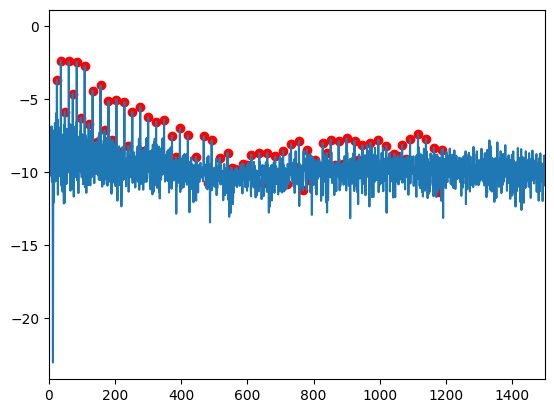

In [268]:
plt.plot(df['full_fft'][0])
plt.scatter(h_index[2:n_harmonics], df['harmonics'][0], c='r')
plt.xlim(0,1500)

## Filter 60Hz


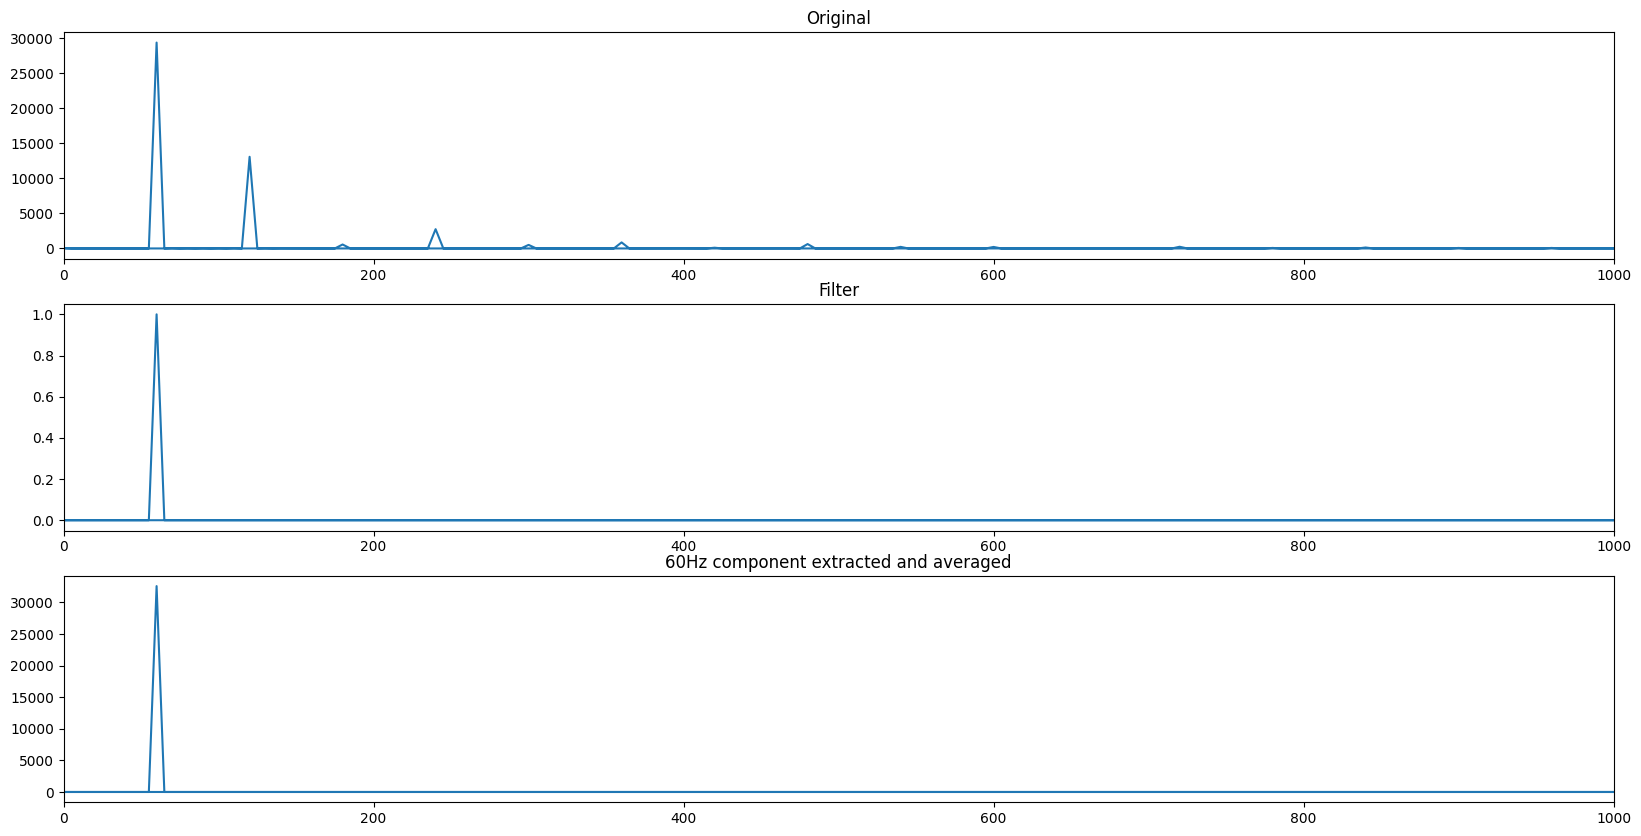

In [ ]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
w_sin = 1-w
avg_sin = abs(df['fft'].apply(lambda x: x*w_sin)).mean()

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, avg_sin)
plt.title('60Hz component extracted and averaged')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, abs(df['fft'][33]))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w_sin)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


C:\Users\alexi\AppData\Local\Temp\ipykernel_38584\2396251472.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(freqs, np.log(abs(df['fft_cut'][30])))


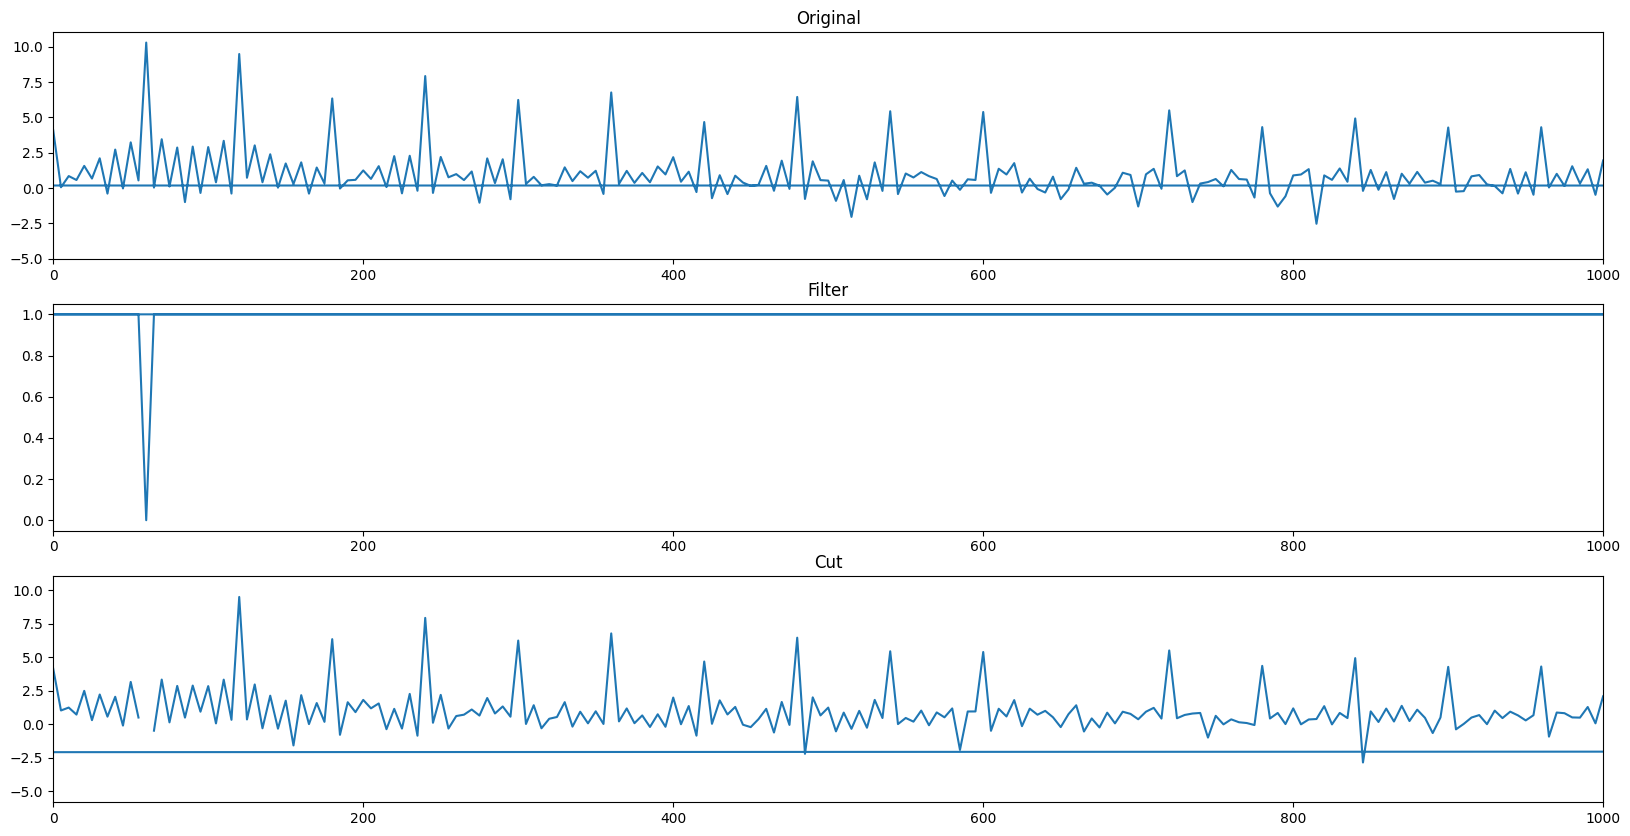

In [71]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
df['fft_cut'] = df['fft'].apply(lambda x: x*w)

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, np.log(abs(df['fft_cut'][30])))
plt.title('Cut')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, np.log(abs(df['fft'][33])))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


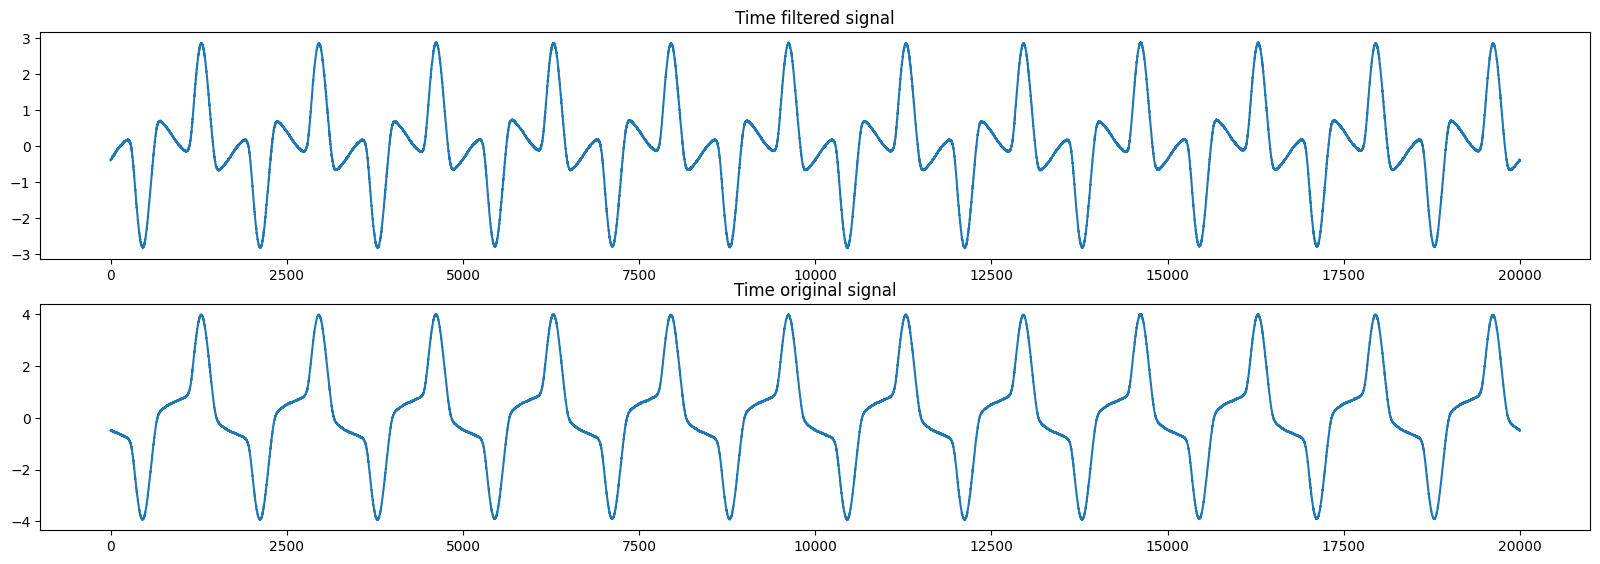

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(np.fft.ifft(df['fft_cut'][20]))
plt.title('Time filtered signal')
plt.subplot(3,1,2)
plt.plot(np.fft.ifft(df['fft'][20]))
plt.title('Time original signal')
plt.plot()
plt.show()

## Create database for training

In [269]:
np.random.seed(42)
N = 5*60

feature = 'harmonics'


list_train_signal = []
labels = df['label'].unique()
feature_size = len(df[feature][0])
min_nb_labels = df['label'].value_counts().min()
dict_counter = {label:0 for label in labels}

for i in range(N):
    random_selection = np.random.randint(0,2, len(labels))
    mix = np.zeros(feature_size)
    present_labels = np.zeros(labels.shape)
    for i,label in enumerate(labels):
        if random_selection[i] == 1:
            mix += df[feature][df['label']=='Heater'].iloc[np.random.randint(0, min_nb_labels)]
            present_labels[i] = 1
            dict_counter[label] += 1


    list_train_signal.append({feature: mix, 'label': present_labels})

df_train = pd.DataFrame(list_train_signal)
df_train.head(20)

,harmonics,label
0,"[-0.9838670019313681, -4.128685952605779, -2.5...","[0.0, 1.0, 0.0, 0.0, 0.0]"
1,"[-0.9839851164214906, -4.127384174873808, -2.5...","[0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[-1.9679023848203125, -8.255597722473684, -5.0...","[0.0, 0.0, 1.0, 0.0, 1.0]"
3,"[-2.9516195347280965, -12.381486096863696, -7....","[0.0, 1.0, 0.0, 1.0, 1.0]"
4,"[-2.951979445869289, -12.383892472604444, -7.6...","[1.0, 1.0, 1.0, 0.0, 0.0]"
5,"[-0.9840955677614036, -4.1246485875655745, -2....","[0.0, 1.0, 0.0, 0.0, 0.0]"
6,"[-3.9357562981013805, -16.50478390213109, -10....","[0.0, 1.0, 1.0, 1.0, 1.0]"
7,"[-2.9519504388425446, -12.378366352919418, -7....","[1.0, 0.0, 1.0, 1.0, 0.0]"
8,"[-0.9838611631846248, -4.127550453265466, -2.5...","[0.0, 0.0, 0.0, 0.0, 1.0]"
9,"[-3.9358686798773617, -16.5022635433461, -10.1...","[0.0, 1.0, 1.0, 1.0, 1.0]"


# train test split

In [270]:
from sklearn.model_selection import train_test_split

feature = 'harmonics'
feature_size = len(df_train[feature][0])
X= np.array(df_train[feature].tolist())
y = np.array(df_train['label'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(210, 98)
(210, 5)


# Multi logistic regressions

In [271]:
#buidling the model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#pca = PCA(n_components=1)

#X= pca.fit_transform(np.array(df_train['AFFTN'].tolist())) 


avg_acc = 0
for i,label in enumerate(labels):
    y_label = y[:,i]
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.3, random_state=42)
    model = LogisticRegression()
    model.fit(Xtrain, ytrain)

    ypred = model.predict(Xtest)
    print(ypred)
    print(ytest)
    avg_acc += accuracy_score(ytest, ypred)
    print(f'accuracy for {label} = {accuracy_score(ytest, ypred)}')

print(f'average accuracy = {avg_acc/len(labels)}')




[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
accuracy for Fun = 0.5555555555555556
[1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
[1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 

C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [215]:
import keras.backend as K
def rmse(predictions, targets):
    return K.sqrt(K.mean((predictions-targets)**2))

In [272]:
# convolution 1d network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten


model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='sigmoid'))

model.compile(loss=rmse, optimizer='adam', metrics=['accuracy', rmse])
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_75 (Conv1D)          (None, 96, 32)            128       
                                                                 
 max_pooling1d_70 (MaxPoolin  (None, 48, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_76 (Conv1D)          (None, 46, 64)            6208      
                                                                 
 max_pooling1d_71 (MaxPoolin  (None, 23, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_77 (Conv1D)          (None, 21, 128)           24704     
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 10, 128)        

Epoch 1/40
7/7 [==============================] - 2s 62ms/step - loss: 0.5415 - accuracy: 0.2190 - rmse: 0.5411 - val_loss: 0.5221 - val_accuracy: 0.0444 - val_rmse: 0.5211
Epoch 2/40
7/7 [==============================] - 0s 58ms/step - loss: 0.5294 - accuracy: 0.1429 - rmse: 0.5311 - val_loss: 0.5397 - val_accuracy: 0.0444 - val_rmse: 0.5396
Epoch 3/40
7/7 [==============================] - 0s 55ms/step - loss: 0.5055 - accuracy: 0.0381 - rmse: 0.5050 - val_loss: 0.4993 - val_accuracy: 0.1000 - val_rmse: 0.4992
Epoch 4/40
7/7 [==============================] - 0s 19ms/step - loss: 0.4999 - accuracy: 0.0905 - rmse: 0.4997 - val_loss: 0.5072 - val_accuracy: 0.1222 - val_rmse: 0.5072
Epoch 5/40
7/7 [==============================] - 0s 19ms/step - loss: 0.5019 - accuracy: 0.3143 - rmse: 0.5021 - val_loss: 0.4917 - val_accuracy: 0.1000 - val_rmse: 0.4917
Epoch 6/40
7/7 [==============================] - 0s 21ms/step - loss: 0.4942 - accuracy: 0.1000 - rmse: 0.4933 - val_loss: 0.4853 - va

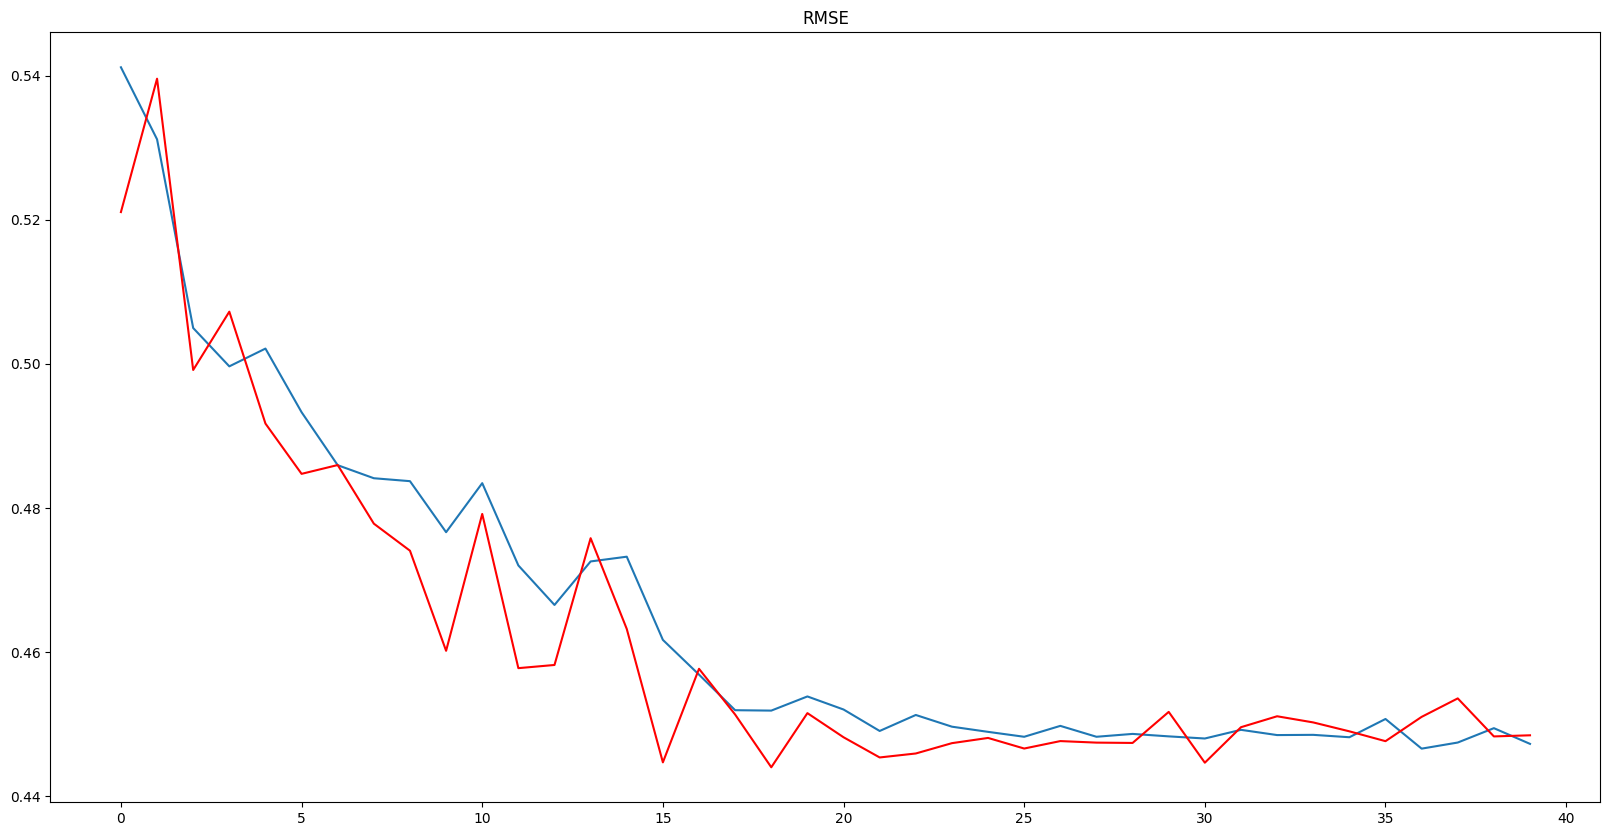

In [273]:
history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_test, y_test))
plt.figure(figsize=(20,10))
plt.title('RMSE')
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'], c='r')
avg = 0
ypred = model.predict(X_test)
for i,label in enumerate(labels):
    ypred_label = ypred[:,i].round()
    ytest_label = y_test[:,i]
    print(f'accuracy for {label} = {accuracy_score(ytest_label, ypred_label)}')
    avg += accuracy_score(ytest_label, ypred_label)
print(f'average accuracy = {avg/len(labels)}')
    

In [91]:
#import MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD
# import confusion matrix
from sklearn.metrics import confusion_matrix

#build the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=feature_size))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#train the model
model.fit(X_train, y_train,
          epochs=30,
          batch_size=2)

#evaluate the model
score = model.evaluate(X_test, y_test, batch_size=128)
print(score)

#predict the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(y_pred)
print(y_test)




Epoch 1/30
26/26 [==============================] - 1s 4ms/step - loss: 31.2004 - accuracy: 0.1346
Epoch 2/30
26/26 [==============================] - 0s 5ms/step - loss: 12.2190 - accuracy: 0.2500
Epoch 3/30
26/26 [==============================] - 0s 4ms/step - loss: 11.6769 - accuracy: 0.1154
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 27.0353 - accuracy: 0.1923
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 50.0952 - accuracy: 0.1731
Epoch 6/30
26/26 [==============================] - 0s 6ms/step - loss: 49.1037 - accuracy: 0.1346
Epoch 7/30
26/26 [==============================] - 0s 3ms/step - loss: 47.1142 - accuracy: 0.2115
Epoch 8/30
26/26 [==============================] - 0s 3ms/step - loss: 75.1479 - accuracy: 0.1731
Epoch 9/30
26/26 [==============================] - 0s 4ms/step - loss: 176.4623 - accuracy: 0.1731
Epoch 10/30
26/26 [==============================] - 0s 5ms/step - loss: 201.2225 - accuracy: 0.2115
Epoch 1

## PCA

C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


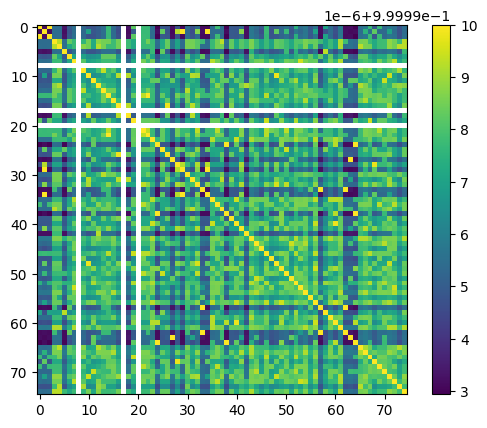

In [435]:
x = df_train['AFFTN'].tolist()
y = df_train['label'].tolist()
x = np.array(x)
#correlation matrix
x_corr = np.corrcoef(x)

plt.imshow(x_corr)
plt.colorbar()
plt.show()

In [437]:
principalComponents.shape

(75, 2)

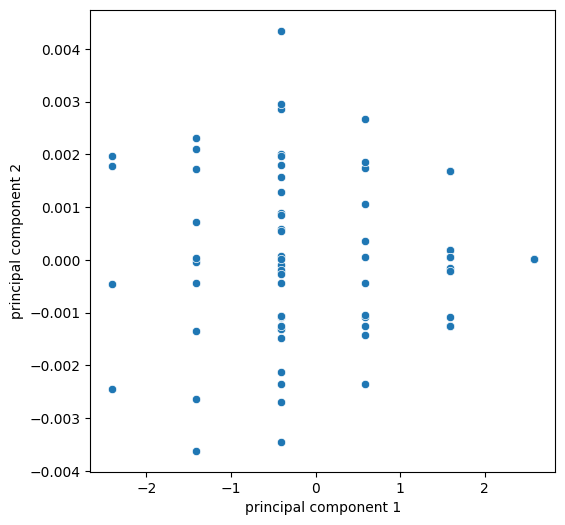

In [441]:
#apply PCA to fft column
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(df_train['AFFTN'].tolist()))

#plot PCA
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

plt.figure(figsize=(6,6))
sns.scatterplot(x=principalDf['principal component 1'], y=principalDf['principal component 2']) 
#save figure
plt.savefig('pca.png')  
plt.show()

In [88]:
print(mat['tpd'][0].dtype)

[('Name', 'O'), ('DateTime', 'O'), ('RangeMin', 'O'), ('RangeMax', 'O'), ('SampleFrequency', 'O'), ('PreSampleCount', 'O'), ('StartValue', 'O'), ('Unit', 'O'), ('Data', 'O')]


In [80]:
print(mat['tpd']['Data'][0][0][0])

[-2.0068629 -2.0049021 -2.0215688 ... -1.9588237 -2.0078433 -1.9941177]
